In [38]:
import os
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge

import xgboost as xgb

import mlflow

In [39]:
mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

2023/06/26 13:11:13 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/lap02105/workking_space/learn_mlops/week_2/mlruns/1', creation_time=1687759873120, experiment_id='1', last_update_time=1687759873120, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [40]:
def read_dataframe(filename):
    df = pd.read_parquet(filename)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)

    df["duration"] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']

    df[categorical] = df[categorical].astype(str)
    return df

In [57]:
df_train = read_dataframe("../dataset/green_tripdata_2021-01.parquet")
df_val = read_dataframe("../dataset/green_tripdata_2021-02.parquet")

In [58]:
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
x_train = dv.fit_transform(train_dict)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
x_val = dv.transform(val_dict)


target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values



In [59]:
# with mlflow.start_run():
#     mlflow.set_tag("developder", "cristian")
#     mlflow.log_param("train-data-path", "dataset/green_tripdata_2021-01.parquet")
#     mlflow.log_param("valid-data-path", "dataset/green_tripdata_2021-02.parquet")
    
#     alpha = 0.001
#     mlflow.log_param("alpha", alpha)
#     lr = Lasso(alpha)
#     lr.fit(x_train, y_train)

#     y_pred = lr.predict(x_val)

#     rmse = mean_squared_error(y_pred, y_val, squared=False)
#     mlflow.log_metric("rmse", rmse)

#     # mlflow.log_artifact(local_path="models", artifact_path="models_pickle/")
#     mlflow.log_artifact("models/lin_reg.bin", artifact_path="models_pickle")

In [60]:
mlflow.xgboost.autolog(disable=True)

In [61]:
os.path.isdir('models/preprocessor.b')

False

In [62]:
with mlflow.start_run():
    mlflow.set_tag("developder", "levan")
    mlflow.set_tag("model", "xgboost")
    mlflow.log_param("train-data-path", "dataset/green_tripdata_2021-01.parquet")
    mlflow.log_param("valid-data-path", "dataset/green_tripdata_2021-02.parquet")
    
    best_params = {
        "learning_rate": 0.35380824252760945,
        "max_depth": 5,
        "min_child_weight": 1.9928832709725457,
        "objective": 'reg:linear',
        "reg_lambda": 0.2652451180565781,
        "req_alpha": 0.04401206822642796,
        "seed":	42,
    }

    x_train = xgb.DMatrix(x_train, label=y_train)
    x_valid = xgb.DMatrix(x_val, label=y_val)

    booster = xgb.train(
        params=best_params,
        dtrain=x_train,
        num_boost_round=10,
        evals=[(x_valid, "validation")],
        early_stopping_rounds=50
    )
    
    mlflow.log_params(best_params)
    y_pred = booster.predict(x_valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    # mlflow.log_artifact(local_path="models", artifact_path="models_pickle/")
    # mlflow.log_artifact("models/lin_reg.bin", artifact_path="models_pickle")
    with open("models/preprocessor.b", "wb") as file_out:
        pickle.dump(dv, file_out)
        
    mlflow.log_artifact('models/preprocessor.b', artifact_path="preprocessor")
    # mlflow.log_artifact('preprocessor.b')

    mlflow.xgboost.log_model(booster, artifact_path="models_mlfow")

[13:34:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[13:34:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "req_alpha" } are not used.

[0]	validation-rmse:15.03743
[1]	validation-rmse:11.33908
[2]	validation-rmse:9.21406
[3]	validation-rmse:8.04368
[4]	validation-rmse:7.41411
[5]	validation-rmse:7.07467
[6]	validation-rmse:6.88357
[7]	validation-rmse:6.77051
[8]	validation-rmse:6.69400
[9]	validation-rmse:6.64812


In [54]:
import mlflow
logged_model = 'runs:/e7854b8694ef49fc8f9bc032ff1744b4/models_mlfow'

# Load model as a PyFuncModel.
# loaded_model = mlflow.pyfunc.load_model(logged_model)
xgboost_model = mlflow.xgboost.load_model(logged_model)
# Predict on a Pandas DataFrame.
# import pandas as pd
# loaded_model.predict(pd.DataFrame(df_train))
y_pred = booster.predict(x_valid)

MlflowException: Run with id=e7854b8694ef49fc8f9bc032ff1744b4 not found

/var/folders/w6/r7qsj8rn7x7dbrq3sk_xkh580000gn/T/ipykernel_48032/1351390157.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/var/folders/w6/r7qsj8rn7x7dbrq3sk_xkh580000gn/T/ipykernel_48032/1351390157.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, lab

<Axes: ylabel='Density'>

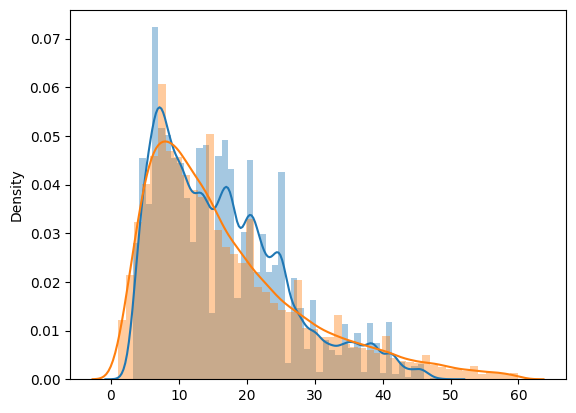

In [55]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')